In [18]:
import glob
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import xarray as xr

plt.style.use("ggplot")

## 1. Get data from RESA2

Code in this section requires a direct connection to Nivabasen.

In [2]:
eng = nivapy.da.connect()

Username:  ···
Password:  ···············


Connection successful.


In [3]:
st_dt = "2000-01-01"
end_dt = "2019-12-31"
par_list = ["Ca", "Mg", "Na", "K", "SO4", "NO3-N", "Cl"]

### 1.1. Get stations

In [4]:
oga_df = pd.read_excel("stations_used_2015.xlsx")
oga_df.dropna(subset="Tr18_Code", inplace=True)
stn_cds = list(oga_df["Tr18_Code"].unique())

stn_df = nivapy.da.select_resa_stations(eng)
stn_df = stn_df.query("station_code in @stn_cds")

assert len(oga_df) == len(stn_df), "Not all stations identified in RESA."
stn_df.to_csv("stations_used_2022.csv")
stn_df.head()

19726 stations in the RESA database.


,station_id,station_code,station_name,latitude,longitude,altitude
13541,23505,DE01,"Schwarzwald, Dürreychbach",48.750167,8.450300,730.0
13542,23506,DE02,"Fichtelgebirge, Eger",50.085000,11.824500,664.0
13543,23507,DE03,"Rothaargebirge, Elberndorfer Bach",50.987833,8.201333,540.0
13545,23509,DE05,"Schwarzwald, Goldersbach",47.878500,8.057000,1100.0
13546,23510,DE06,"Hunsrück, Gräfenbach",49.924000,7.619167,515.0


In [5]:
nivapy.spatial.quickmap(stn_df, popup="station_name", cluster=True, kartverket=True)

### 1.2. Get parameters

In [6]:
par_df = nivapy.da.select_resa_station_parameters(stn_df, st_dt, end_dt, eng)
par_df = par_df.query("parameter_name in @par_list")
assert len(par_df) == len(par_list), "Not all parameters available."
par_df

34 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
4,11,Ca,mg/l
6,7,Cl,mg/l
12,12,K,mg/l
16,13,Mg,mg/l
19,5,NO3-N,µg/l N
20,14,Na,mg/l
25,8,SO4,mg/l


### 1.3. Get water chemistry

In [7]:
def convert_to_microequivalents(df, sea_salt_corr=False):
    """Basic conversion from mass/l to microequivalents/l.

    Arguments:
        df {DataFrame} -- Raw water chemistry from Nivabasen
        sea_salt_corr {bool} -- Whether to also apply sea-salt correction

    Raises:
        ValueError: If the appropriate unit factor cannot be identified.
        Assertion error if sea_salt_corr is True and 'Cl_mg/l' is not in 'df'

    Returns:
        DataFrame -- 'df' is returned with additional columns added.
    """
    if sea_salt_corr:
        assert (
            "Cl_mg/l" in df.columns
        ), "Column 'Cl_mg/l' is required if 'sea_salt_corr' is True."

    chem_prop_df = pd.read_csv(r"chemical_properties.csv", sep=";")

    for idx, row in chem_prop_df.iterrows():
        par_unit = row["par"]
        valency = row["valency"]
        molar_mass = row["molar_mass"]
        cl_ratio = row["cl_ratio"]

        if par_unit in df.columns:
            par, unit = par_unit.split("_")

            if unit[0] == "m":
                factor = 1000
            elif unit[0] == "µ":
                factor = 1
            else:
                raise ValueError("Unit factor could not be identified.")

            df[f"{par}_µekv/l"] = df[par_unit] * valency * factor / molar_mass

            if sea_salt_corr and cl_ratio:
                df[f"{par}*_µekv/l"] = df[f"{par}_µekv/l"] - (
                    cl_ratio * df["Cl_µekv/l"]
                )

    # Remove unwanted columns
    for col in ["Cl*_µekv/l", "NO3-N*_µekv/l"]:
        if col in df.columns:
            del df[col]

    return df

In [8]:
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_df, par_df, st_dt, end_dt, eng, lod_flags=False, drop_dups=True
)
wc_df.rename({"NO3-N_µg/l N": "NO3-N_µg/l"}, axis="columns", inplace=True)
wc_df = convert_to_microequivalents(wc_df, sea_salt_corr=True)
wc_df = wc_df.query("(depth1 == 0) and (depth2 == 0)")
wc_df["year"] = wc_df["sample_date"].dt.year
wc_df = (
    wc_df.groupby(["station_id", "station_code", "station_name", "year"])
    .mean()
    .reset_index()
)
wc_df.to_csv("water_chem.csv")
wc_df.head()

,station_id,station_code,station_name,year,depth1,depth2,Ca_mg/l,Cl_mg/l,K_mg/l,Mg_mg/l,...,Ca*_µekv/l,Mg_µekv/l,Mg*_µekv/l,Na_µekv/l,Na*_µekv/l,K_µekv/l,K*_µekv/l,SO4_µekv/l,SO4*_µekv/l,NO3-N_µekv/l
0,23505,DE01,"Schwarzwald, Dürreychbach",2000,0.0,0.0,2.361538,1.900000,1.633333,1.000000,...,115.515244,82.287595,71.783548,45.839328,-1.747566,41.773231,41.118579,71.830106,64.512003,86.586504
1,23505,DE01,"Schwarzwald, Dürreychbach",2001,0.0,0.0,2.391667,2.891667,2.375000,1.000000,...,116.332754,82.287595,66.301172,32.622880,-37.440068,60.741688,59.273547,74.432646,66.031618,87.259101
2,23505,DE01,"Schwarzwald, Dürreychbach",2002,0.0,0.0,2.483333,2.341667,1.633333,1.000000,...,121.481167,82.287595,69.341817,86.994345,30.257492,41.773231,40.584333,84.495801,77.692663,83.333333
3,23505,DE01,"Schwarzwald, Dürreychbach",2003,0.0,0.0,2.091667,2.533333,2.375000,1.000000,...,101.735917,82.287595,68.282198,86.994345,25.613550,60.741688,59.455478,62.460962,55.100983,88.924578
4,23505,DE01,"Schwarzwald, Dürreychbach",2004,0.0,0.0,2.784615,2.669231,2.476923,0.715385,...,136.174094,58.867280,44.110581,86.994345,22.320856,63.348416,61.993209,75.273467,67.518671,77.417229


## 4. Get deposition

### 4.1. "Standard" EMEP data from 2000 to 2019

Available from [here](https://www.emep.int/mscw/mscw_moddata.html) (`2000-2018 (Type2) and 2019 (Type1)`.

In [9]:
# List files to process
file_paths = [
    f"https://thredds.met.no/thredds/dodsC/data/EMEP/2021_Reporting/EMEP01_rv4.42_year.{year}met_{year}emis_rep2021.nc"
    for year in range(2000, 2019)
]

# Data for 2019 have a different naming convention/url
file_paths += [
    r"https://thredds.met.no/thredds/dodsC/data/EMEP/2021_Reporting/EMEP01_rv4.42_year.2019met_2019emis.nc"
]

In [10]:
# Open datasets
ds = xr.open_mfdataset(
    file_paths,
    combine="by_coords",
)
ds

<xarray.Dataset>
Dimensions:             (lon: 1200, lat: 520, time: 20)
Coordinates:
  * lon                 (lon) float64 -29.95 -29.85 -29.75 ... 89.75 89.85 89.95
  * lat                 (lat) float64 30.05 30.15 30.25 ... 81.75 81.85 81.95
  * time                (time) datetime64[ns] 2000-07-02 ... 2019-07-02T12:00:00
Data variables: (12/49)
    SURF_ugN_NOX        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ugN_RDN        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ugN_OXN        (time, lat, lon) float64 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_PREC           (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_SOX            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_OXN            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    ...                  ...
    SURF_ug_ECFINE      (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_ECCOARSE    (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25        (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM_coarse   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM10_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
Attributes:
    vert_coord:                      atmosphere_hybrid_sigma_pressure_coordinate
    Conventions:                     CF-1.6 for coordinates
    model:                           EMEP_MSC-W
    author_of_run:                   emepctm group
    created_date:                    20210814
    created_hour:                    000608.038
    projection:                      lon lat
    period_type:                     fullrun
    run_label:                       rv4_42
    lastmodified_date:               20210816
    lastmodified_hour:               000013.715
    DODS_EXTRA.Unlimited_Dimension:  time

In [11]:
# Load data from URL into memory to improve performance later
ds = ds.load()

In [12]:
# Pars of interest
par_list = [
    "DDEP_SOX_m2Grid",
    "WDEP_SOX",
    "DDEP_OXN_m2Grid",
    "WDEP_OXN",
    "DDEP_RDN_m2Grid",
    "WDEP_RDN",
]

# Check N units are consistent
for par in par_list:
    unit = ds[par].attrs["units"]
    print(f"{par: <20}", unit)
    assert unit in ["mgS/m2", "mgN/m2"], "Units not consistent."

DDEP_SOX_m2Grid      mgS/m2
WDEP_SOX             mgS/m2
DDEP_OXN_m2Grid      mgN/m2
WDEP_OXN             mgN/m2
DDEP_RDN_m2Grid      mgN/m2
WDEP_RDN             mgN/m2


In [13]:
# Calculate total oxidised S
ds["DEP_SOX"] = ds["WDEP_SOX"] + ds["DDEP_SOX_m2Grid"]
ds["DEP_SOX"].attrs["units"] = "mgS/m2"

# Calculate total oxidised N
ds["DEP_OXN"] = ds["WDEP_OXN"] + ds["DDEP_OXN_m2Grid"]
ds["DEP_OXN"].attrs["units"] = "mgN/m2"

# Calculate total reduced N
ds["DEP_RDN"] = ds["WDEP_RDN"] + ds["DDEP_RDN_m2Grid"]
ds["DEP_RDN"].attrs["units"] = "mgN/m2"

# Calculate total N
ds["DEP_TOTN"] = (
    ds["WDEP_OXN"] + ds["WDEP_RDN"] + ds["DDEP_OXN_m2Grid"] + ds["DDEP_RDN_m2Grid"]
)
ds["DEP_TOTN"].attrs["units"] = "mgN/m2"

In [14]:
par_list = par_list + ["DEP_SOX", "DEP_TOTN"]
df_list = []
for idx, row in stn_df.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    stn_id = row["station_id"]

    # Get time series
    df = (
        ds[par_list]
        .sel(lat=lat, lon=lon, method="nearest")
        .to_dataframe()
        .reset_index()
    )
    df["station_id"] = stn_id
    df["year"] = df["time"].dt.year

    df_list.append(df)

# Combine results
df = pd.concat(df_list, sort=True).reset_index(drop=True)
df = df[["station_id", "year"] + par_list]
par_unit = [i + "_mgpm2" for i in par_list]
df.columns = ["station_id", "year"] + par_unit

df.head()

,station_id,year,DDEP_SOX_m2Grid_mgpm2,WDEP_SOX_mgpm2,DDEP_OXN_m2Grid_mgpm2,WDEP_OXN_mgpm2,DDEP_RDN_m2Grid_mgpm2,WDEP_RDN_mgpm2,DEP_SOX_mgpm2,DEP_TOTN_mgpm2
0,23505,2000,193.149231,578.728699,520.615784,714.637451,212.879761,532.078552,771.877930,1980.211548
1,23505,2001,205.534439,510.884430,506.671204,668.916748,230.336060,492.915466,716.418884,1898.839478
2,23505,2002,188.160385,522.814758,497.195923,719.803528,220.274033,502.302887,710.975159,1939.576416
3,23505,2003,216.410950,457.507202,537.629517,586.855530,241.050690,510.704681,673.918152,1876.240356
4,23505,2004,189.498306,438.772888,505.518433,647.594421,215.249146,505.768921,628.271179,1874.130859


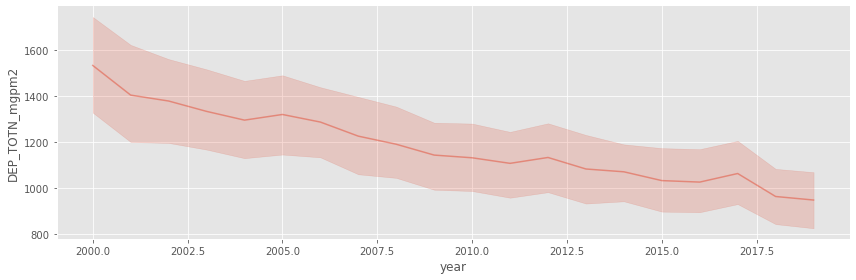

In [15]:
sn.relplot(
    data=df,
    x="year",
    y="DEP_TOTN_mgpm2",
    height=4,
    aspect=3,
    kind="line",
    legend=False,
    alpha=0.5,
)

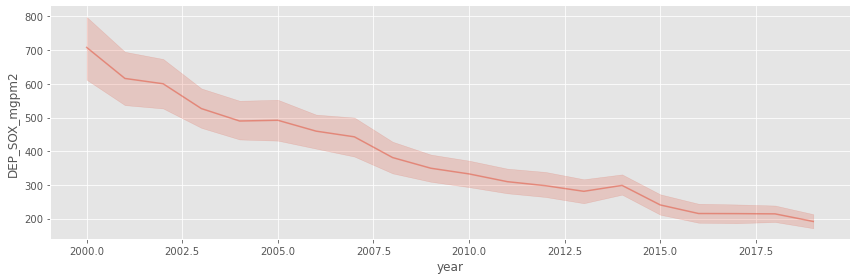

In [16]:
sn.relplot(
    data=df,
    x="year",
    y="DEP_SOX_mgpm2",
    height=4,
    aspect=3,
    kind="line",
    legend=False,
    alpha=0.5,
)

### 4.2. EMEP Scenarios

Prepared for the GP review and downloaded from [here](https://aerocom-classic.met.no/DATA/download/GP_review_WGE/) (see e-mail from Heleen received 05.05.2022 at 12:25 for details).

In [22]:
# Pars of interest
par_list = [
    "DDEP_SOX_m2Grid",
    "WDEP_SOX",
    "DDEP_OXN_m2Grid",
    "WDEP_OXN",
    "DDEP_RDN_m2Grid",
    "WDEP_RDN",
]

In [23]:
search_path = r"../../../gp_review_2022/emep_data/*.nc"
flist = glob.glob(search_path)
for fpath in flist:
    met, emis, scen = os.path.split(fpath)[1].split("_")[2:5]

    ds = xr.open_dataset(fpath)
    df2 = (
        ds[par_list]
        .sel(lat=stn_df["latitude"], lon=stn_df["longitude"], method="nearest")
        .to_dataframe()
        .reset_index()
    )
    df2["station_id"] = stn_df["station_id"]

KeyError: 'DDEP_SOX_m2Grid'

In [21]:
ds

<xarray.Dataset>
Dimensions:             (lon: 1200, lat: 520, time: 1)
Coordinates:
  * lon                 (lon) float64 -29.95 -29.85 -29.75 ... 89.75 89.85 89.95
  * lat                 (lat) float64 30.05 30.15 30.25 ... 81.75 81.85 81.95
  * time                (time) datetime64[ns] 2005-07-02T12:00:00
Data variables: (12/18)
    WDEP_SOX            (time, lat, lon) float32 ...
    WDEP_OXN            (time, lat, lon) float32 ...
    WDEP_RDN            (time, lat, lon) float32 ...
    DDEP_SOX_m2Conif    (time, lat, lon) float32 ...
    DDEP_SOX_m2Seminat  (time, lat, lon) float32 ...
    DDEP_SOX_m2Water_D  (time, lat, lon) float32 ...
    ...                  ...
    DDEP_OXN_m2Crops    (time, lat, lon) float32 ...
    DDEP_RDN_m2Conif    (time, lat, lon) float32 ...
    DDEP_RDN_m2Seminat  (time, lat, lon) float32 ...
    DDEP_RDN_m2Water_D  (time, lat, lon) float32 ...
    DDEP_RDN_m2Decid    (time, lat, lon) float32 ...
    DDEP_RDN_m2Crops    (time, lat, lon) float32 ...
Attributes:
    vert_coord:         atmosphere_hybrid_sigma_pressure_coordinate
    Conventions:        CF-1.6 for coordinates
    model:              EMEP_MSC-W
    author_of_run:      emepctm group
    created_date:       20220409
    created_hour:       012252.550
    projection:         lon lat
    period_type:        fullrun
    run_label:          rv4_45
    lastmodified_date:  20220411
    lastmodified_hour:  015524.886

## 5. Get runoff

In [24]:
par_df = nivapy.da.get_nve_gts_api_parameters()
par_df

,Name,Fullname,NoDataValue,RawUnit,HumanReadableUnit,TimeResolutionInMinutes,FirstDateInTimeSerie
0,rr,Døgnnedbør v2.0,65535,mm,mm,1440,1957-01-01
1,tm,Døgntemperatur v2.0,65535,Kelvin,Celcius,1440,1957-01-01
4,swe,Snømengde v2.0.1,65535,mm,mm,1440,1957-01-01
5,snowload,Snølast,65535,kg/m2,kg/m2,1440,2000-01-01
6,sd,Snødybde v2.0.1,65535,mm,cm,1440,1957-01-01
7,swepr,Snømengde i prosent v2.0.1,65535,%,%,1440,1957-01-01
8,age,Snøens alder v2.0.1,255,Dager,Dager,1440,1957-01-01
9,qtt,Regn og snøsmelting v2.0.1,255,mm,mm,1440,1957-01-01
10,qtt7d,Regn og snøsmelting siste uke,65535,mm,mm,1440,1957-01-01
11,gwb_q,Avrenning,65535,mm,mm,1440,1957-01-01


In [25]:
pars = ["gwb_q"]

st_dt = "2000-01-01"
end_dt = "2019-12-31"

res_df = nivapy.da.get_nve_gts_api_time_series(
    stn_df,
    pars,
    st_dt,
    end_dt,
    id_col="station_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
)
res_df.head()

Looping over parameters:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over grid cells:   0%|          | 0/59 [00:00<?, ?it/s]

HTTPError: HTTP Error 400: Bad Request